In [165]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader , random_split
import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [166]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [167]:
directory = './CROPS/crops_image'

data = datasets.ImageFolder(root = directory, 
                                  transform = train_transforms)

train_data , test_data = random_split(data, [2640 , 660])

train_data.dataset.transform = train_transforms
test_data.dataset.transform = test_transforms

In [168]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 2640
Number of testing examples: 660


In [169]:
from torch.utils.data import DataLoader
BATCH_SIZE = 64

train_iterator = DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)


test_iterator = DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [170]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [171]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [172]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [173]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

In [174]:
pretrained_model = models.resnet50(pretrained = True)

In [175]:
IN_FEATURES = pretrained_model.fc.in_features 
# OUTPUT_DIM = len(test_data.classes)
unique_classes = set()
for _, label in test_data.dataset.samples:
    unique_classes.add(label)

OUTPUT_DIM = len(unique_classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [176]:
pretrained_model.fc = fc

In [177]:
model = ResNet(resnet50_config, OUTPUT_DIM)

In [178]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

### Training the Model

Next we'll move on to training our model. As in previous notebooks, we'll use the learning rate finder to set a suitable learning rate for our model.

We start by initializing an optimizer with a very low learning rate, defining a loss function (`criterion`) and device, and then placing the model and the loss function on to the device.

In [179]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

We define the learning rate finder class.

See notebook 3 for a reminder on how this works.

In [180]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

We then define our learning rate finder and run the range test.

In [181]:
END_LR = 10
NUM_ITER = 100

# lr_finder = LRFinder(model, optimizer, criterion, device)
# lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Next, we define a function to plot the results of the range test.

In [182]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()


We can see that the loss reaches a minimum at around $3x10^{-3}$.

A good learning rate to choose here would be the middle of the steepest downward curve - which is around $1x10^{-3}$.

In [183]:
# plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

We can then set the learning rates of our model using discriminative fine-tuning - a technique used in transfer learning where later layers in a model have higher learning rates than earlier ones.

We use the learning rate found by the learning rate finder as the maximum learning rate - used in the final layer - whilst the remaining layers have a lower learning rate, gradually decreasing towards the input. 

In [184]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [185]:
EPOCHS = 5
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS) #total_steps = TOTAL_STEPS

One other thing we are going to implement is top-k accuracy. Our task is to classify an image into one of 200 classes of bird, however some of these classes look very similar and it is even difficult for a human to correctly label them. So, maybe we should be more lenient when calculating accuracy? 

One method of solving this is using top-k accuracy, where the prediction is labelled correct if the correct label is in the top-k predictions, instead of just being the first. Our `calculate_topk_accuracy` function calculates the top-1 accuracy as well as the top-k accuracy, with $k=5$ by default.

We use `.reshape` instead of view here as the slices into tensors cause them to become non-contiguous which means `.view` throws an error. As a rule of thumb, if you are aiming to change the size/shape of sliced tensors then you should probably use `.reshape` instead of `.view`.

**Note:** our value of k should be chosen sensibly. If we had a dataset with 10 classes then a k of 5 isn't really that informative.

In [186]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

Next up is the training function. This is similar to all the previous notebooks, but with the addition of the `scheduler` and calculating/returning top-k accuracy.

The scheduler is updated by calling `scheduler.step()`. This should always be called **after** `optimizer.step()` or else the first learning rate of the scheduler will be skipped. 

Not all schedulers need to be called after each training batch, some are only called after each epoch. In that case, the scheduler does not need to be passed to the `train` function and can be called in the main training loop.

In [187]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
        
    return epoch_loss, epoch_acc_1

The evaluation function is also similar to previous notebooks, with the addition of the top-k accuracy.

As the one cycle scheduler should only be called after each parameter update, it is not called here as we do not update parameters whilst evaluating.

In [188]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
        
    return epoch_loss, epoch_acc_1

Next, a small helper function which tells us how long an epoch has taken.

In [189]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we can train our model!

We get around 80% top-1 and 95% top-5 validation accuracy.

In [190]:
best_valid_loss = float('inf')
tr_los =[]
te_los=[]
tr_ac=[]
te_ac=[]
for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1 = train(model, train_iterator, optimizer, criterion, scheduler, device)

        
    tr_los.append(train_loss)
    tr_ac.append(train_acc_1)
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ')
    
    

    test_loss, test_acc_1 = evaluate(model, test_iterator, criterion, device)

    te_los.append(test_loss)
    te_ac.append(test_acc_1)
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ')
    

Epoch: 01 | Epoch Time: 4m 14s
	Train Loss: 1.234 | Train Acc @1:  65.18% | 
	Test Loss: 1.132 | Test Acc @1:  78.35% | 
Epoch: 02 | Epoch Time: 4m 12s
	Train Loss: 0.272 | Train Acc @1:  91.03% | 
	Test Loss: 0.428 | Test Acc @1:  86.73% | 


The test accuracies are a little lower than the validation accuracies, but not by so much that we should be concerned.

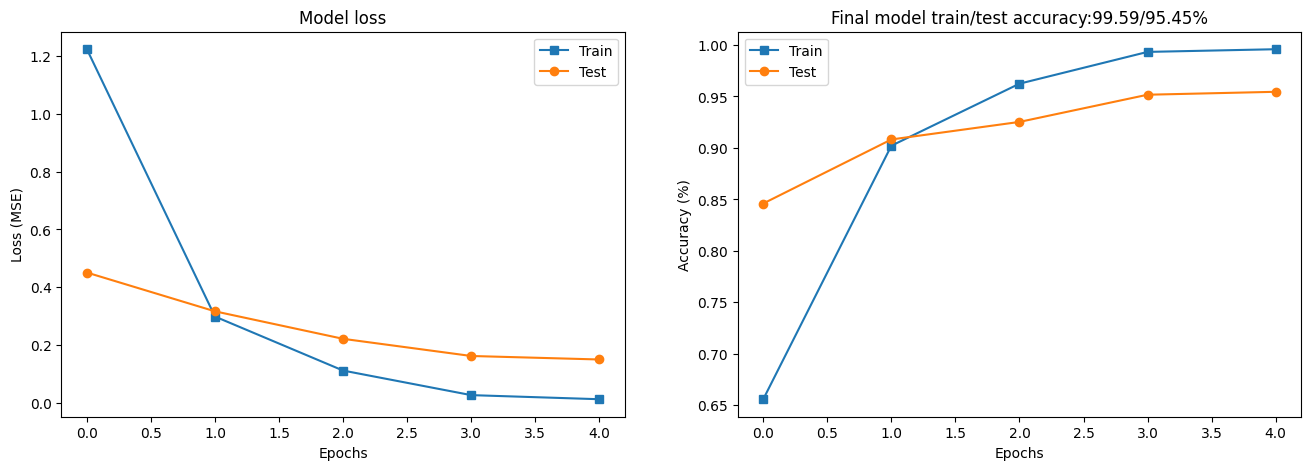

In [ ]:
import matplotlib.pylab as plt
fig , ax = plt.subplots(1,2,figsize = (16,5))
ax[0].plot(tr_los, 's-', label='Train')
ax[0].plot(te_los , 'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(tr_ac , 's-', label='Train')
ax[1].plot(te_ac , 'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy:{100*train_acc_1:.2f}/{100*test_acc_1:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# model.load_state_dict(torch.load('tut5-model.pt'))

# test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

# print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
#       f'Test Acc @5: {test_acc_5*100:6.2f}%')

### Examining the Model

We'll be doing the same examinations of the model as done in previous notebooks.

First, we get the predictions for each image in the test set...

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator)

... which we then use to get the predicted labels.

In [ ]:
pred_labels = torch.argmax(probs, 1)

We then use this to plot a confusion matrix.

A 200x200 confusion matrix is pretty large, so we've increased the figure size and removed the colorbar. The text is still too small to read, but all we care about is that the diagonals are generally darker than the rest of the matrix - which they are.

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes ,normalize=False):
    
    fig = plt.figure(figsize = (10, 10));

    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    # cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm_display.plot(values_format='d' if not normalize else '.2f', cmap='Blues', ax=ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 10)
    plt.ylabel('True Label', fontsize = 10)
    

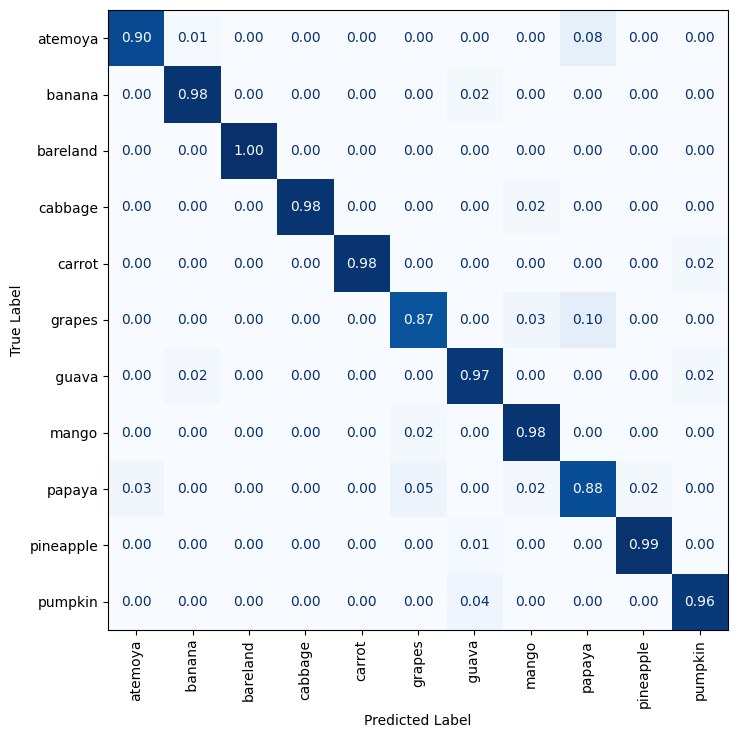

In [ ]:
classes = ['atemoya' ,' banana' , 'bareland' , 'cabbage' , 'carrot' , 'grapes' , ' guava' , 'mango' , 'papaya' , 'pineapple'  , 'pumpkin']
plot_confusion_matrix(labels, pred_labels, classes, normalize=True)

We can then get all of the correct predictions, filter them out, and then sort all of the incorrect predictions based on how confident they were on their incorrect prediction.

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot the most incorrectly predicted images along with the predicted class and the actual class. 

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

From the names of the classes (and a bit of image searching) we can see that the incorrect predictions are usually sensible, e.g. magnolia warbler and cape may warbler, marsh wren and carolina wren.

The most incorrectly predicted image might also be a mislabeled example as worm eating warblers do not have a black and white underside.

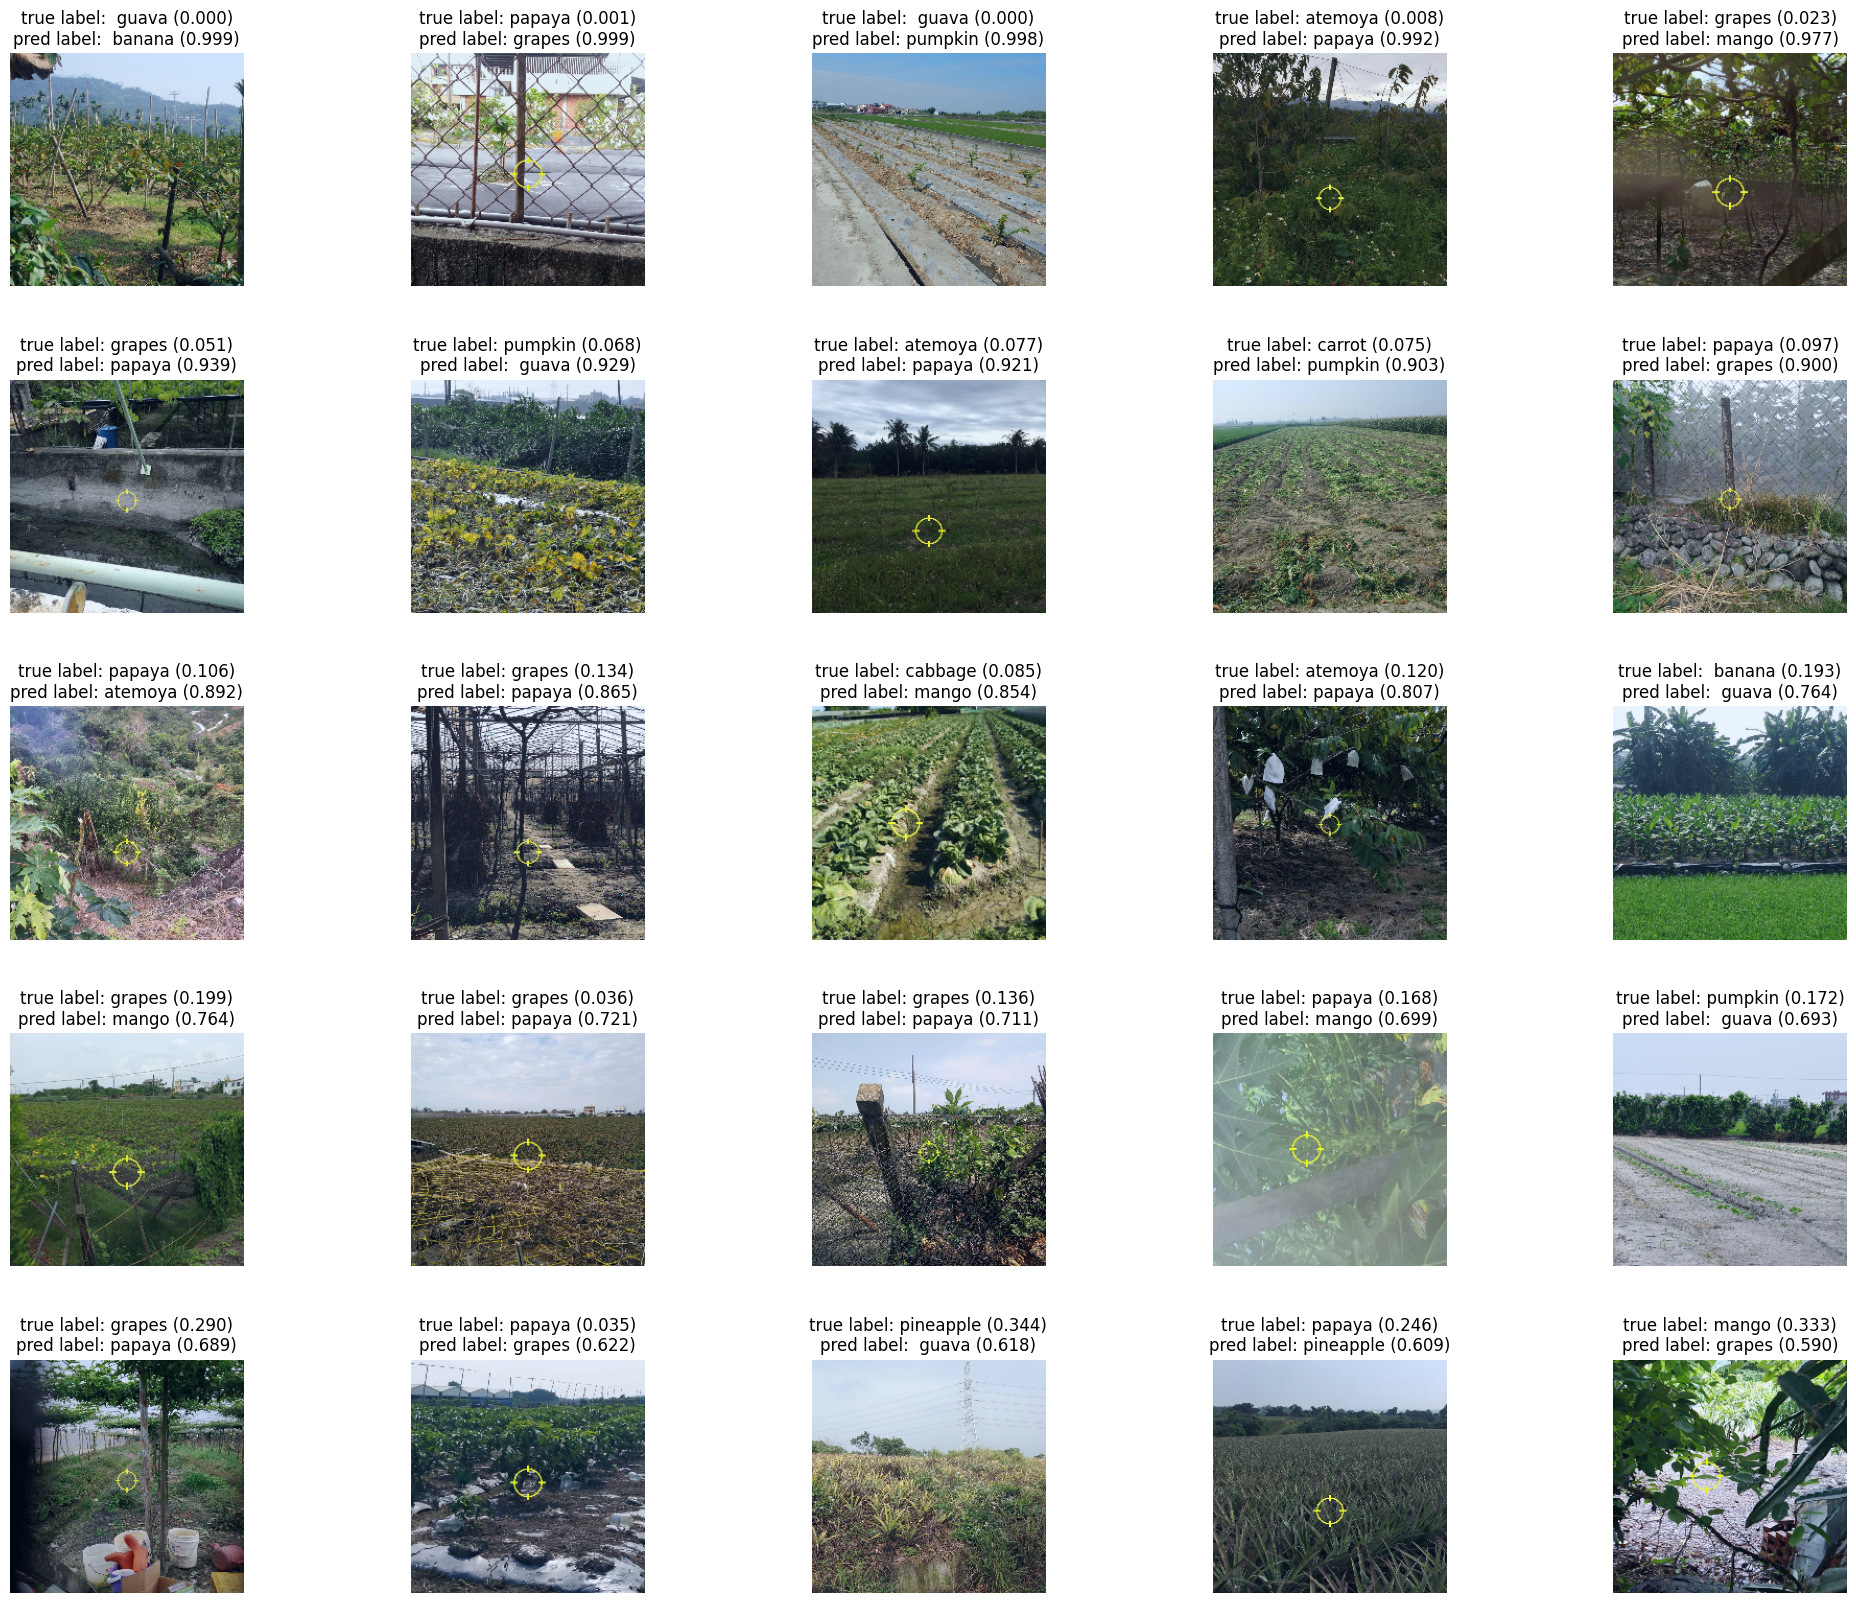

In [ ]:
N_IMAGES = 30

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [ ]:
torch.save(model ,'mymodel.pth')